In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from modules.dataset import Dataset, LABELS

2022-12-06 20:13:00.026733: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def get_y_true(data):
    y_true=[]
    for X,y in data:
        for label in y:
            y_true.append(label)
    y_true = tf.Variable(y_true)
    return y_true

In [3]:
fold_num = 3
dataset = Dataset()
train_dataset, test_dataset = dataset.get_kfold(fold_num, sample=False)

y_true = get_y_true(test_dataset)

# Modeling
model = tf.keras.models.load_model("results/models/EfficientNetB0_None_fold_{}.h5".format(fold_num))

2022-12-06 20:13:03.282641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 20:13:05.083825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31901 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:17:00.0, compute capability: 8.0


In [4]:
y_preds = model.predict(test_dataset)

2022-12-06 20:13:29.176243: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-06 20:13:30.372255: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-06 20:13:30.373650: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-06 20:13:30.373703: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-06 20:13:30.374778: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-06 20:13:30.374910: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


      7/Unknown - 9s 26ms/step

2022-12-06 20:13:34.541978: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1402/1402 [==============================] - 52s 31ms/step


## Average: tf.AUC

In [5]:
m = tf.keras.metrics.AUC(multi_label=True, num_thresholds=200)
m.update_state(y_true, y_preds)
m.result().numpy()

0.75063926

## Each Label

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv("~/ChestXray-14/results/confusion/EfficientNetB0_None_fold_{}.csv".format(fold_num))
df.head()

,thresholds,TP,TN,FP,FN
0,-1.000000e-07,"[12117.0, 2333.0, 928.0, 3994.0, 1078.0, 467.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[10307.0, 20091.0, 21496.0, 18430.0, 21346.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,5.025126e-03,"[12117.0, 2327.0, 912.0, 3994.0, 1070.0, 455.0...","[0.0, 1108.0, 2036.0, 0.0, 1758.0, 10071.0, 43...","[10307.0, 18983.0, 19460.0, 18430.0, 19588.0, ...","[0.0, 6.0, 16.0, 0.0, 8.0, 12.0, 11.0, 17.0, 1..."
2,1.005025e-02,"[12117.0, 2315.0, 894.0, 3994.0, 1042.0, 436.0...","[0.0, 2570.0, 5007.0, 0.0, 5035.0, 13463.0, 81...","[10307.0, 17521.0, 16489.0, 18430.0, 16311.0, ...","[0.0, 18.0, 34.0, 0.0, 36.0, 31.0, 40.0, 48.0,..."
3,1.507538e-02,"[12117.0, 2287.0, 866.0, 3994.0, 996.0, 426.0,...","[0.0, 3786.0, 7414.0, 0.0, 7778.0, 15067.0, 10...","[10307.0, 16305.0, 14082.0, 18430.0, 13568.0, ...","[0.0, 46.0, 62.0, 0.0, 82.0, 41.0, 76.0, 92.0,..."
4,2.010050e-02,"[12117.0, 2259.0, 850.0, 3994.0, 963.0, 419.0,...","[0.0, 4804.0, 9107.0, 2.0, 9792.0, 15941.0, 12...","[10307.0, 15287.0, 12389.0, 18428.0, 11554.0, ...","[0.0, 74.0, 78.0, 0.0, 115.0, 48.0, 106.0, 134..."


ROC
---
Y-axis: $TPR = \frac{TP} {(TP + FN)}$ <br>
X-axis: $FPR = \frac{FP} {(FP + TN)}$

In [8]:
from sklearn import metrics
from functools import partial

In [9]:
def preprocessing(x, label=0):
    return np.array(eval(x))[label]

In [10]:
def drop_duplicates(tpr, fpr):
    df = pd.DataFrame({
        "TPR": tpr,
        "FPR": fpr
    })
    df = df.drop_duplicates()
    return df["TPR"].values, df["FPR"].values

In [11]:
def get_tpr_fpr(index):
    func = partial(preprocessing, label=index)

    TP = df["TP"].apply(func)
    TN = df["TN"].apply(func)
    FP = df["FP"].apply(func)
    FN = df["FN"].apply(func)

    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)

    tpr, fpr = drop_duplicates(tpr, fpr)
    return tpr, fpr

## AUC by sklearn AUC Trapezoidal

Class 1: 0.748266939783987
Class 2: 0.7618656587025391
Class 3: 0.7783046344628671
Class 4: 0.6810547345706568
Class 5: 0.7943610243940852
Class 6: 0.8766192223675651
Class 7: 0.7697796048196734
Class 8: 0.7118215353551043
Class 9: 0.8464373204925236
Class 10: 0.6897804121101553
Class 11: 0.7367179985674818
Class 12: 0.8546188364008303
Class 13: 0.6316570422808141
Class 14: 0.7467729137280776
Class 15: 0.6315320317979892
Average AUC: 0.7506393273222901


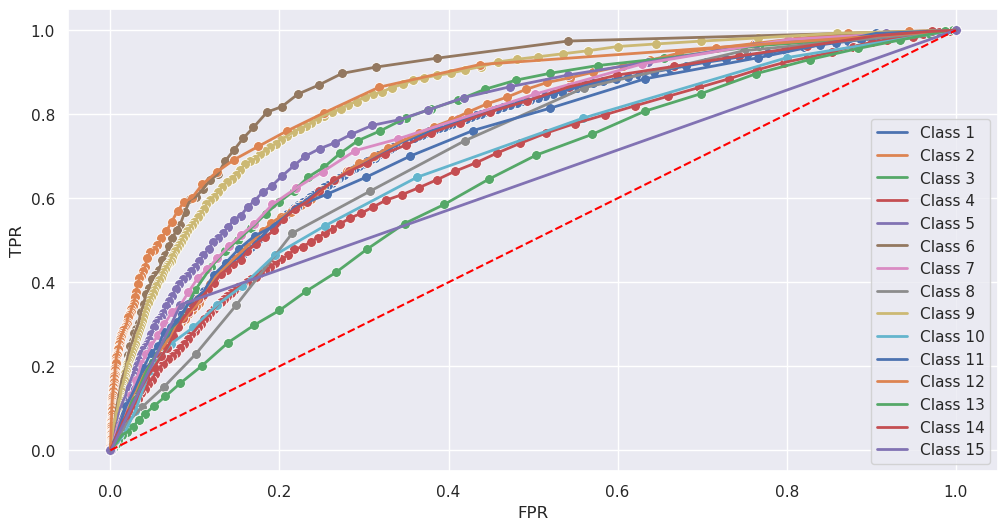

In [25]:
label_index = 0
sns.set_theme()
plt.figure(figsize=(12, 6))

auc_list = []
for i in range(15):
    tpr, fpr = get_tpr_fpr(i)
    sns.lineplot(
        x=fpr,
        y=tpr,
        linewidth=2,
        label=f"Class {i+1}"
    )
    auc = metrics.auc(fpr, tpr)
    auc_list.append(auc)
    print(f"Class {i+1}: {auc}")
    sns.scatterplot(x=fpr, y=tpr, s=50, marker="o")
    # break

print(f"Average AUC: {np.mean(auc_list)}")
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", color="red")
plt.xlabel("FPR")
plt.ylabel("TPR");

## AUC by Mid-point rules

In [15]:
import matplotlib.patches as mpatches

Class 1: 0.7482669397839866
Class 2: 0.7618656587025392
Class 3: 0.7783046344628672
Class 4: 0.6810547345706569
Class 5: 0.7943610243940855
Class 6: 0.8766192223675651
Class 7: 0.7697796048196734
Class 8: 0.7118215353551043
Class 9: 0.8464373204925237
Class 10: 0.6897804121101555
Class 11: 0.7367179985674819
Class 12: 0.8546188364008309
Class 13: 0.6316570422808142
Class 14: 0.7467729137280775
Class 15: 0.6315320317979892
Average AUC: 0.7506393273222902


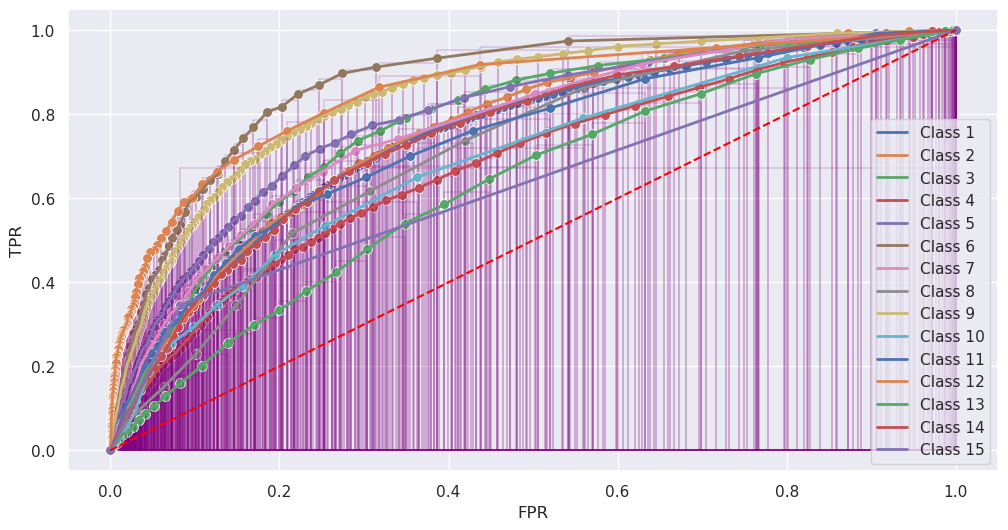

In [28]:
label_index = 0
sns.set_theme()
plt.figure(figsize=(12, 6))

auc_list = []
for i in range(15):
    tpr, fpr = get_tpr_fpr(i)
    sns.lineplot(
        x=fpr,
        y=tpr,
        linewidth=2,
        label=f"Class {i+1}"
    )

    # Draw Rectangle
    for idx, x in enumerate(fpr[:-1]):
        rect=mpatches.Rectangle(xy=(x,0),
                                width=fpr[idx+1] - x,
                                height=(tpr[idx] + tpr[idx+1])/2,
                                fill = False,
                                color = "purple",
                                linewidth = 0.2)
        plt.gca().add_patch(rect)


    delta = (tpr[1:] + tpr[:-1]) /2
    distance = abs(fpr[1:] - fpr[:-1])
    auc = sum(delta * distance)
    auc_list.append(auc)

    print(f"Class {i+1}: {auc}")
    sns.scatterplot(x=fpr, y=tpr, s=50, marker="o")
    # break

print(f"Average AUC: {np.mean(auc_list)}")
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", color="red")
plt.xlabel("FPR")
plt.ylabel("TPR");